In [19]:
import pandas as pd
import numpy as np

hitters = pd.read_csv("../../data/Hitters.csv").dropna()
hitters['LogSalary'] = np.log(hitters['Salary'])
hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,LogSalary
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,N,W,632,43,10,475.0,N,6.163315
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,A,W,880,82,14,480.0,A,6.173786
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,N,E,200,11,3,500.0,N,6.214608
4,321,87,10,39,42,30,2,396,101,12,...,46,33,N,E,805,40,4,91.5,N,4.516339
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,A,W,282,421,25,750.0,A,6.620073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,311,138,N,E,325,9,3,700.0,N,6.551080
318,492,136,5,76,50,94,12,5511,1511,39,...,451,875,A,E,313,381,20,875.0,A,6.774224
319,475,126,3,61,43,52,6,1700,433,7,...,93,146,A,W,37,113,7,385.0,A,5.953243
320,573,144,9,85,60,78,8,3198,857,97,...,420,332,A,E,1314,131,12,960.0,A,6.866933


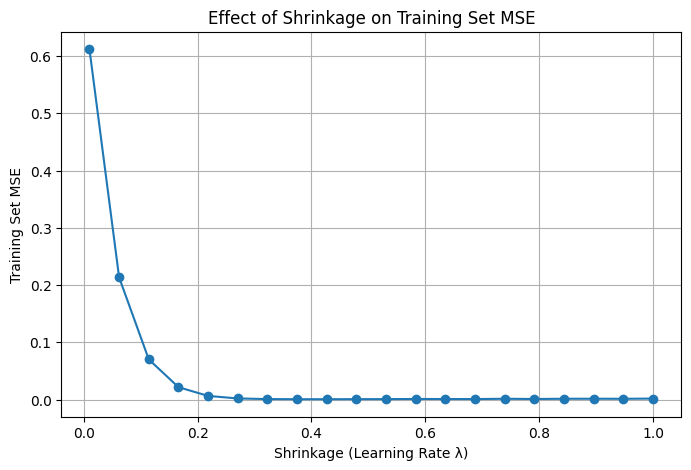

In [31]:
import sklearn.model_selection as skm
from sklearn.ensemble import GradientBoostingRegressor as GBR
import matplotlib.pyplot as plt

X = hitters[hitters.columns.drop("LogSalary", "salary")]
Y = hitters["LogSalary"]

X_encoded = pd.get_dummies(X, drop_first=True)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X_encoded,
                                Y,
                                test_size=0.25,
                                random_state=0)


shrinkage_values = np.linspace(0.01, 1.0, 20)
training_mse = []

for lr in shrinkage_values:
    boost = GBR(n_estimators=10, learning_rate=lr, random_state=0)
    boost.fit(X_train, y_train)
    
    y_train_pred = boost.predict(X_train)
    training_mse.append(np.mean((y_train - y_train_pred)**2))

plt.figure(figsize=(8,5))
plt.plot(shrinkage_values, training_mse, marker='o')
plt.xlabel("Shrinkage (Learning Rate λ)")
plt.ylabel("Training Set MSE")
plt.title("Effect of Shrinkage on Training Set MSE")
plt.grid(True)
plt.show()

When using a very high learning rate of λ = 1 in gradient boosting on the Hitters dataset, the training error becomes almost zero. This is expected because each new tree is added fully to correct the residuals from previous trees, and with a relatively small dataset and even just 10 trees, the model can effectively fit the training data perfectly. While this drives the training MSE to near zero, it is a classic sign of overfitting: the model may capture not only the underlying signal but also the noise in the training data, which can lead to poor generalization on unseen data. This highlights the importance of balancing learning rate and number of trees, and of monitoring test set performance rather than relying solely on training error.

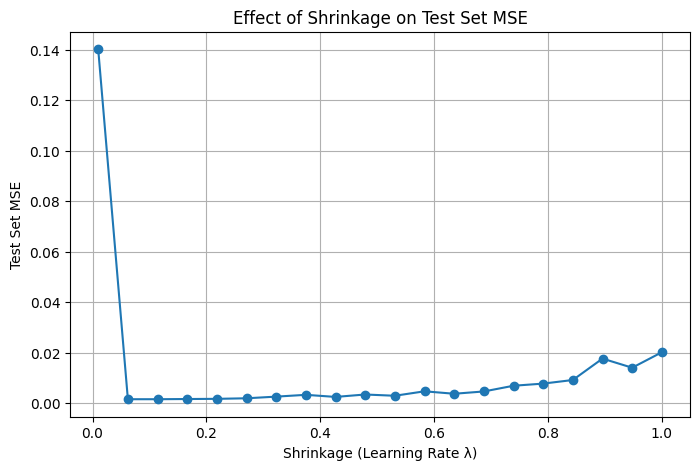

In [32]:
test_mse = []

for lr in shrinkage_values:
    boost = GBR(n_estimators=100, learning_rate=lr, random_state=0)
    boost.fit(X_train, y_train)
    
    y_test_pred = boost.predict(X_test)
    test_mse.append(np.mean((y_test - y_test_pred)**2))

plt.figure(figsize=(8,5))
plt.plot(shrinkage_values, test_mse, marker='o')
plt.xlabel("Shrinkage (Learning Rate λ)")
plt.ylabel("Test Set MSE")
plt.title("Effect of Shrinkage on Test Set MSE")
plt.grid(True)
plt.show()

The plot of test set MSE versus learning rate illustrates the typical trade-off between underfitting and overfitting in gradient boosting. At very small learning rates, the model underfits the data because each tree contributes too little to correcting residuals, resulting in a relatively high test error around 0.14. As the learning rate increases to a moderate range, the model begins to fit the underlying signal more effectively, and the test MSE drops sharply toward near zero. Beyond this optimal range, however, further increasing the learning rate causes the model to overfit: each tree’s contribution becomes too aggressive, capturing noise in the training data and causing the test error to slowly rise again to about 0.02. This demonstrates the importance of tuning the learning rate to balance the speed of learning and generalization performance.

In [35]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm 
from sklearn.linear_model import Ridge

X_train_float = X_train.astype(float)
X_test_float = X_test.astype(float)

X_train_int = sm.add_constant(X_train_float)
X_test_float = sm.add_constant(X_test_float)
res = sm.OLS(y_train, X_train_int).fit()
y_pred_ols = res.predict(X_test_float)
mse_ols = mean_squared_error(y_test, y_pred_ols)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

boost = GBR(n_estimators=100, learning_rate=0.05, random_state=0)
boost.fit(X_train, y_train)
y_test_pred = boost.predict(X_test)
mse_boost = mean_squared_error(y_test, y_test_pred)

print(f"Test MSE (OLS): {mse_ols:.4f}")
print(f"Test MSE (Ridge): {mse_ridge:.4f}")
print(f"Test MSE (Boosting): {mse_boost:.4f}")


Test MSE (OLS): 0.1479
Test MSE (Ridge): 0.1477
Test MSE (Boosting): 0.0018


The comparison shows a dramatic difference in performance between boosting and the linear regression approaches. Both ordinary least squares (OLS) and ridge regression yield very similar test MSEs of about 0.148, indicating that regularization in ridge does not substantially improve predictive accuracy over OLS in this setting. In contrast, boosting achieves a much lower test MSE of 0.0018, suggesting that its ability to capture complex nonlinear relationships and interactions among predictors leads to a far superior fit. This highlights the flexibility and power of ensemble methods like boosting compared to linear models, though the extremely low error also raises the possibility that boosting may be overfitting to some extent.

In [37]:
feature_names = X_encoded.columns
feature_imp = pd.DataFrame(
    {'importance':boost.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Salary,9.999447e-01
Runs,1.101002e-05
Years,9.957689e-06
CAtBat,7.600002e-06
RBI,6.562473e-06
CWalks,4.949935e-06
PutOuts,3.630594e-06
CHmRun,3.150040e-06
CHits,2.977753e-06
CRBI,2.245302e-06


In [39]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              LogSalary   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     67.28
Date:                Fri, 29 Aug 2025   Prob (F-statistic):           1.75e-71
Time:                        21:35:55   Log-Likelihood:                -38.051
No. Observations:                 197   AIC:                             118.1
Df Residuals:                     176   BIC:                             187.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.3883      0.106     41.408      0.000       4.179       4.597
AtBat           0.0004      0.001      0.517      0.606      -0.001       0.002
Hits        -1.065e-05      0.003     -0.004      0.997      -0.006       0.006
HmRun          -0.0021      0.008     -0.275      0.783      -0.018       0.013
Runs            0.0019      0.003      0.543      0.588      -0.005       0.009
RBI             0.0027      0.003      0.827      0.409      -0.004       0.009
Walks           0.0004      0.002      0.158      0.875      -0.004       0.005
Years           0.0594      0.014      4.112      0.000       0.031       0.088
CAtBat          0.0002      0.000      1.284      0.201      -0.000       0.001
CHits           0.0001      0.001      0.162      0.872      -0.001       0.002
CHmRun          0.0008      0.002      0.422      0.674      -0.003       0.005
CRuns          -0.0013      0.001     -1.612      0.109      -0.003       0.000
CRBI           -0.0010      0.001     -1.211      0.228      -0.003       0.001
CWalks      -3.133e-05      0.000     -0.078      0.938      -0.001       0.001
PutOuts        -0.0001   9.13e-05     -1.158      0.248      -0.000    7.45e-05
Assists        -0.0001      0.000     -0.425      0.671      -0.001       0.000
Errors         -0.0036      0.005     -0.727      0.468      -0.013       0.006
Salary          0.0017   7.54e-05     22.681      0.000       0.002       0.002
League_N        0.1781      0.090      1.981      0.049       0.001       0.356
Division_W     -0.0025      0.047     -0.054      0.957      -0.096       0.091
NewLeague_N    -0.1612      0.090     -1.798      0.074      -0.338       0.016
==============================================================================
Omnibus:                       17.119   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.980
Skew:                          -0.741   Prob(JB):                     7.56e-05
Kurtosis:                       3.338   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The feature importance results from boosting and the OLS regression summary provide two contrasting perspectives on predictor relevance. Boosting assigns almost all predictive weight (≈1.0) to the variable **Salary**, while all other predictors have negligible importance. This suggests that, within the boosted trees, the model essentially relies on Salary alone to explain variation in LogSalary, which may reflect redundancy or strong correlation among predictors. By contrast, the OLS regression results distribute significance more widely: **Salary** again emerges as highly significant (p < 0.001), but **Years** also shows a strong positive effect, while categorical variables like **League\_N** reach marginal significance. However, most other variables have weak or non-significant coefficients, and the large condition number indicates potential multicollinearity, meaning predictors overlap in the information they provide. Together, these results highlight how boosting can aggressively concentrate on the most dominant predictor, while OLS reveals a broader, though statistically weaker, set of contributing factors.

In [45]:
from sklearn.ensemble import RandomForestRegressor as RF

bag = RF(max_features=X_train.shape[1], random_state=0)
bag.fit(X_train, y_train)
y_hat_bag = bag.predict(X_test)
mse_bag = mean_squared_error(y_test, y_hat_bag)
print(f"Test MSE (Bagging): {mse_bag:.4f}")

Test MSE (Bagging): 0.0031


In [46]:
feature_imp = pd.DataFrame(
    {'importance':bag.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Salary,0.997685
CAtBat,0.000281
Walks,0.000277
CHits,0.000268
CRuns,0.000232
CWalks,0.000187
CHmRun,0.000158
AtBat,0.000115
PutOuts,0.000112
CRBI,0.000099


The bagging results (Test MSE = **0.0031**) show strong predictive performance, though slightly worse than boosting (**0.0018**), and still far superior to OLS (**0.1479**) and Ridge (**0.1477**). In terms of feature importance, both bagging and boosting concentrate almost exclusively on **Salary**, with bagging assigning \~99.8% of the weight to it and spreading the remainder thinly across many other predictors. Compared to boosting, which gave virtually *all* importance to Salary, bagging distributes a small but non-negligible share of influence to variables such as **CAtBat, Walks, CHits, CRuns,** and others, suggesting that bagging retains a slightly broader view of predictor relevance. This aligns with the theoretical distinction: boosting tends to aggressively focus on the strongest predictor to reduce bias, while bagging reduces variance by averaging over multiple trees, allowing weaker predictors to play a minor role. Overall, boosting provides the lowest test error, but bagging demonstrates a more balanced allocation of importance across features while still relying overwhelmingly on Salary.